# Exercise

A bug prediction classifier for the forrest project in order to determine piece of code that will likely contain problems.

Build a Titanic classifier:

1. [Load the Forrest datasets](#ds)
1. [Explore data](#ed)
1. [Write a data preparation pipeline](#pipeline)
1. [Build a forrest classifier](#build)
1. [Compute performance metrics](#metrics)
1. [Build other models](#other)

In [1]:
%run ../scripts/setup.ipynb

## 1. Load the Forrest datasets <a class='anchor' id='ds'></a>

Let's load the data.

In [2]:
versions = ['0.6', '0.7', '0.8'] 
FORREST_PATH = [os.path.join(DATA_PATH, f"forrest-{v}") for v in versions]
FORREST_FILE = [f"forrest-{v}.csv" for v in versions]

In [3]:
def load_data(filename, path):
    data_list = pd.DataFrame()
    for p, f in zip(path, filename):
        df = pd.read_csv(os.path.join(p, f))
        data_list = pd.concat([data_list, df], axis=0) 
    return data_list

In [4]:
forrest_data = load_data(FORREST_FILE, FORREST_PATH)

## 2. Explore data <a class='anchor' id='ed'></a>

The data contains some software metrics values for the `forrest` software project with versions `0.6`, `0.7`, `0.8`.

Let's take a peek at the top few rows of the forrest set.

In [5]:
forrest_data.head()

name  version                                          name.1  wmc  dit  \
0  forrest      0.6     org.apache.forrest.conf.SkinconfTransformer    3    5   
1  forrest      0.6  org.apache.forrest.log.ForrestLogTargetFactory    2    5   
2  forrest      0.6       org.apache.forrest.conf.ForrestConfModule   10    3   
3  forrest      0.6        org.apache.forrest.conf.ForrestConfUtils    7    1   
4  forrest      0.6           org.apache.forrest.conf.AntProperties    7    4   

   noc  cbo  rfc  lcom  ca  ...   dam  moa       mfa       cam  ic  cbm  \
0    0    5   24     3   0  ...  0.00    0  0.933333  0.500000   1    1   
1    0    6   12     1   0  ...  0.00    0  0.933333  0.750000   1    1   
2    0   17   42    37   0  ...  1.00    1  0.500000  0.366667   1    1   
3    0    4   16    21   2  ...  0.75    0  0.000000  0.238095   0    0   
4    0    5   44    21   4  ...  0.00    0  0.900000  0.309524   2    6   

         amc  max_cc  avg_cc  bug  
0  91.000000       1  0.6667    0  
1  20.500000       1  0.5000    1  
2  32.400000       3  1.2000    0  
3  13.714286       5  1.4286    0  
4  30.285714       5  1.7143    0  

[5 rows x 24 columns]

The attributes have the following meaning:
* `name`: the name of the project
* `version`: the version of the project. This can be a categorical variable
* `name.1`: the class for which measures have been computed.
* `wmc`: weighted methods per class expresses the complexity of a class.
* `dit`: depth of inheritance tree 
* `noc`: number of children  
* `cbo`: coupling between object classes counts the number of classes the given class depends on.
* `rfc`: response for a class
* `lcom`: lack of cohesion in methods
* `ca`: afferent couplings
* `ce`: efferent couplings  
* `npm`: number of public methods    
* `lcom3`: lack of cohesion in methods
* `loc`: lines of code    
* `dam`: data access metric  
* `moa`: measure of aggregation    
* `mfa`: measure of functional abstraction  
* `cam`: cohesion among methods of class  
* `ic`: inheritance coupling     
* `cbm`: coupling between methods    
* `amc`: average method complexity   
* `max_cc`: maximum McCabe's cyclomatic complexity  
* `avg_cc`: average McCabe's cyclomatic complexity
* `bug`: number of bugs 

In [6]:
forrest_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67 entries, 0 to 31
Data columns (total 24 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   name     67 non-null     object 
 1   version  67 non-null     float64
 2   name.1   67 non-null     object 
 3   wmc      67 non-null     int64  
 4   dit      67 non-null     int64  
 5   noc      67 non-null     int64  
 6   cbo      67 non-null     int64  
 7   rfc      67 non-null     int64  
 8   lcom     67 non-null     int64  
 9   ca       67 non-null     int64  
 10  ce       67 non-null     int64  
 11  npm      67 non-null     int64  
 12  lcom3    67 non-null     float64
 13  loc      67 non-null     int64  
 14  dam      67 non-null     float64
 15  moa      67 non-null     int64  
 16  mfa      67 non-null     float64
 17  cam      67 non-null     float64
 18  ic       67 non-null     int64  
 19  cbm      67 non-null     int64  
 20  amc      67 non-null     float64
 21  max_cc   67 non-nu

In [7]:
forrest_data.describe()

version        wmc        dit        noc        cbo        rfc  \
count  67.000000  67.000000  67.000000  67.000000  67.000000  67.000000   
mean    0.738806   5.537313   2.895522   0.149254  10.328358  26.597015   
std     0.065030   3.862517   1.558305   0.874794   5.628359  16.231339   
min     0.600000   1.000000   1.000000   0.000000   2.000000   1.000000   
25%     0.700000   3.000000   1.500000   0.000000   5.000000  13.000000   
50%     0.700000   4.000000   3.000000   0.000000  10.000000  24.000000   
75%     0.800000   7.000000   4.000000   0.000000  15.000000  40.000000   
max     0.800000  17.000000   6.000000   6.000000  24.000000  67.000000   

            lcom         ca         ce        npm  ...        dam        moa  \
count  67.000000  67.000000  67.000000  67.000000  ...  67.000000  67.000000   
mean   11.716418   1.417910   9.313433   4.313433  ...   0.609701   0.402985   
std    20.547658   1.859857   6.221198   2.850885  ...   0.470995   0.759978   
min     0.000000   0.000000   0.000000   1.000000  ...   0.000000   0.000000   
25%     1.000000   0.000000   4.000000   3.000000  ...   0.000000   0.000000   
50%     1.000000   1.000000   9.000000   3.000000  ...   1.000000   0.000000   
75%    14.000000   2.000000  14.000000   5.500000  ...   1.000000   0.500000   
max    88.000000   7.000000  24.000000  14.000000  ...   1.000000   3.000000   

             mfa        cam         ic        cbm        amc     max_cc  \
count  67.000000  67.000000  67.000000  67.000000  67.000000  67.000000   
mean    0.546560   0.473706   0.597015   0.805970  33.646690   3.119403   
std     0.353762   0.174323   0.697609   1.221509  23.710366   3.426821   
min     0.000000   0.213675   0.000000   0.000000   0.000000   1.000000   
25%     0.178571   0.353571   0.000000   0.000000  16.200000   1.000000   
50%     0.692308   0.444444   0.000000   0.000000  30.000000   2.000000   
75%     0.818182   0.555556   1.000000   1.000000  39.062500   4.000000   
max     0.933333   1.000000   2.000000   6.000000  91.000000  17.000000   

          avg_cc        bug  
count  67.000000  67.000000  
mean    1.275452   0.328358  
std     0.815871   1.185622  
min     0.500000   0.000000  
25%     0.800000   0.000000  
50%     1.000000   0.000000  
75%     1.500000   0.000000  
max     4.000000   8.000000  

[8 rows x 22 columns]

Saving figure forrest_attribute_histogram_plots


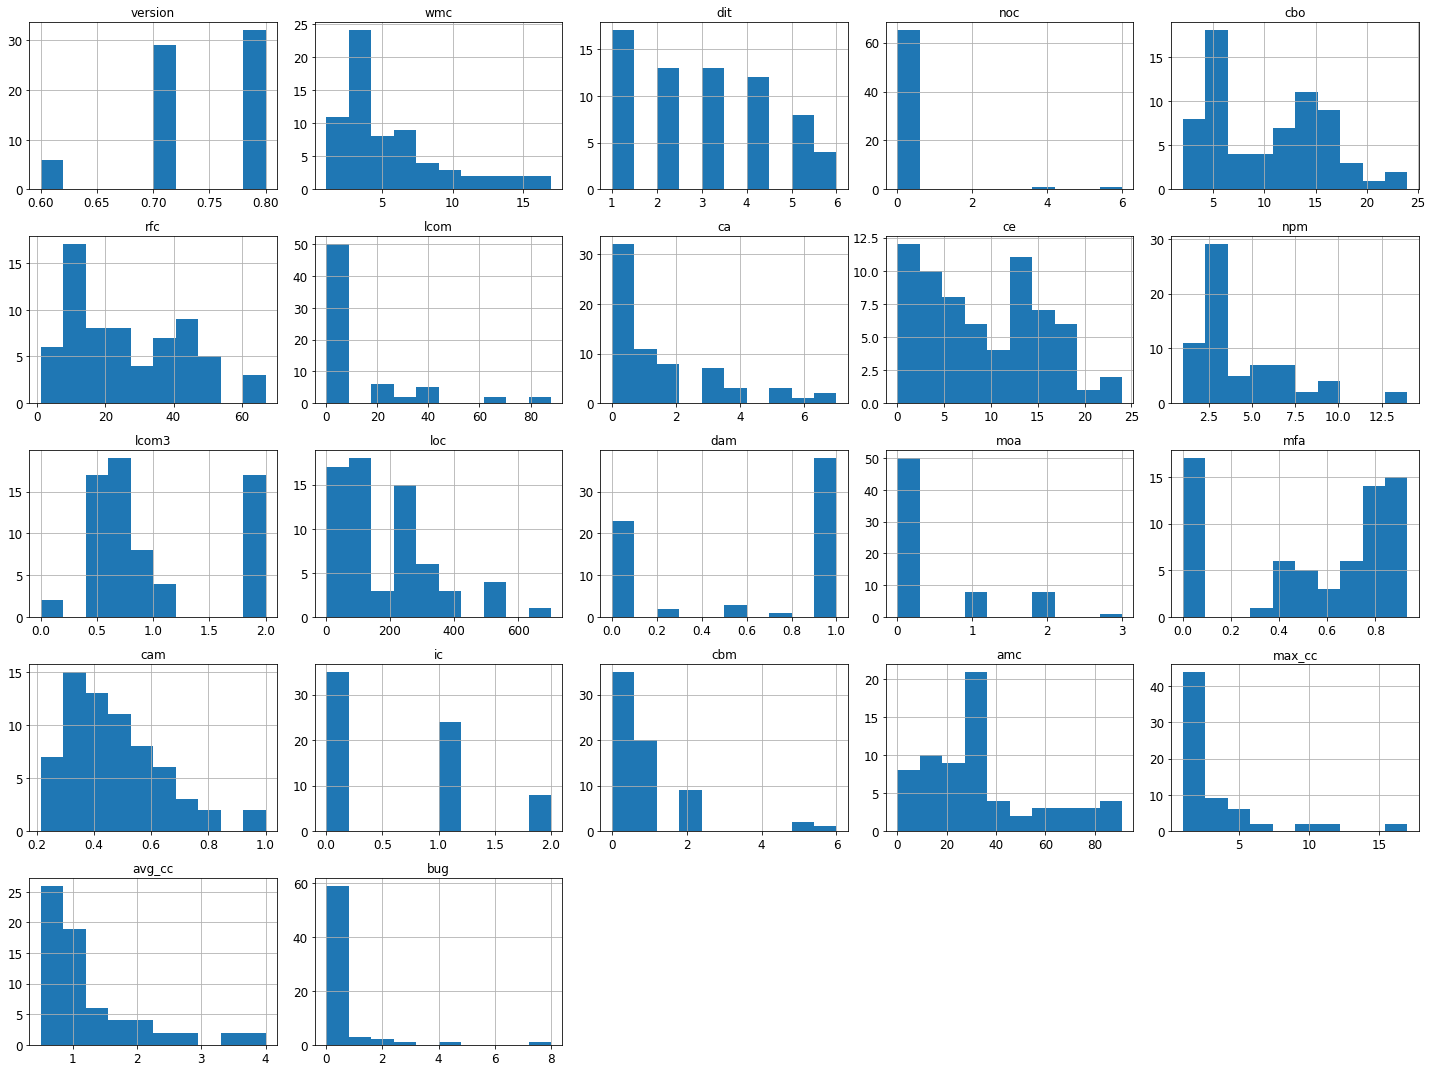

In [8]:
forrest_data.hist(figsize=(20,15))
save_fig("forrest_attribute_histogram_plots")
plt.show()

<AxesSubplot:>

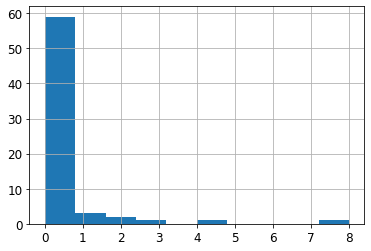

In [9]:
forrest_data['bug'].hist()

In [10]:
forrest_data['bug'].value_counts()

0    59
1     3
2     2
3     1
4     1
8     1
Name: bug, dtype: int64

Transform the `version` attribute in the categorical variable.

In [11]:
forrest_data.loc[:, 'version'] = forrest_data['version'].astype(str)

Define a new attribute called `defect` that sets `1` if the instance contains bugs otherwise `0`. 

In [12]:
forrest_data.loc[:,'defect']=(forrest_data['bug']>0).astype(int)

In [13]:
forrest_data.describe()

wmc        dit        noc        cbo        rfc       lcom  \
count  67.000000  67.000000  67.000000  67.000000  67.000000  67.000000   
mean    5.537313   2.895522   0.149254  10.328358  26.597015  11.716418   
std     3.862517   1.558305   0.874794   5.628359  16.231339  20.547658   
min     1.000000   1.000000   0.000000   2.000000   1.000000   0.000000   
25%     3.000000   1.500000   0.000000   5.000000  13.000000   1.000000   
50%     4.000000   3.000000   0.000000  10.000000  24.000000   1.000000   
75%     7.000000   4.000000   0.000000  15.000000  40.000000  14.000000   
max    17.000000   6.000000   6.000000  24.000000  67.000000  88.000000   

              ca         ce        npm      lcom3  ...        moa        mfa  \
count  67.000000  67.000000  67.000000  67.000000  ...  67.000000  67.000000   
mean    1.417910   9.313433   4.313433   1.011352  ...   0.402985   0.546560   
std     1.859857   6.221198   2.850885   0.614020  ...   0.759978   0.353762   
min     0.000000   0.000000   1.000000   0.000000  ...   0.000000   0.000000   
25%     0.000000   4.000000   3.000000   0.591667  ...   0.000000   0.178571   
50%     1.000000   9.000000   3.000000   0.750000  ...   0.000000   0.692308   
75%     2.000000  14.000000   5.500000   1.583333  ...   0.500000   0.818182   
max     7.000000  24.000000  14.000000   2.000000  ...   3.000000   0.933333   

             cam         ic        cbm        amc     max_cc     avg_cc  \
count  67.000000  67.000000  67.000000  67.000000  67.000000  67.000000   
mean    0.473706   0.597015   0.805970  33.646690   3.119403   1.275452   
std     0.174323   0.697609   1.221509  23.710366   3.426821   0.815871   
min     0.213675   0.000000   0.000000   0.000000   1.000000   0.500000   
25%     0.353571   0.000000   0.000000  16.200000   1.000000   0.800000   
50%     0.444444   0.000000   0.000000  30.000000   2.000000   1.000000   
75%     0.555556   1.000000   1.000000  39.062500   4.000000   1.500000   
max     1.000000   2.000000   6.000000  91.000000  17.000000   4.000000   

             bug     defect  
count  67.000000  67.000000  
mean    0.328358   0.119403  
std     1.185622   0.326709  
min     0.000000   0.000000  
25%     0.000000   0.000000  
50%     0.000000   0.000000  
75%     0.000000   0.000000  
max     8.000000   1.000000  

[8 rows x 22 columns]

In [14]:
forrest_data[["name.1"]]

name.1
0         org.apache.forrest.conf.SkinconfTransformer
1      org.apache.forrest.log.ForrestLogTargetFactory
2           org.apache.forrest.conf.ForrestConfModule
3            org.apache.forrest.conf.ForrestConfUtils
4               org.apache.forrest.conf.AntProperties
..                                                ...
27  org.apache.forrest.locationmap.AbstractWrappin...
28     org.apache.forrest.sourcetype.SourceTypeAction
29          org.apache.forrest.locationmap.lm.ActNode
30  org.apache.forrest.locationmap.WildcardLocatio...
31        org.apache.forrest.conf.SkinconfTransformer

[67 rows x 1 columns]

Our goal is to train the best model we can by using the training data, then make our predictions on the test data.

In [15]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(forrest_data, test_size=0.2, random_state=42)

forrest = train_set.drop(["name",'version',"defect"], axis=1) # drop labels for training set
forrest_labels = train_set["defect"].copy()

In [16]:
train_set.head()

name version                                             name.1  wmc  \
27  forrest     0.8  org.apache.forrest.locationmap.AbstractWrappin...    7   
28  forrest     0.7  org.apache.forrest.locationmap.AbstractWrappin...    7   
13  forrest     0.8  org.apache.forrest.locationmap.WildcardLocatio...    2   
1   forrest     0.7       org.apache.forrest.locationmap.lm.SelectNode    3   
6   forrest     0.8        org.apache.forrest.conf.AntPropertiesModule    5   

    dit  noc  cbo  rfc  lcom  ca  ...  moa       mfa       cam  ic  cbm  \
27    2    0   11   26     0   0  ...    0  0.454545  0.485714   0    0   
28    2    0   11   26     0   0  ...    0  0.454545  0.485714   0    0   
13    4    0    2    4     1   0  ...    0  0.900000  0.666667   1    1   
1     3    0   13   30     0   2  ...    2  0.818182  0.444444   2    2   
6     4    0   12   20     6   0  ...    0  0.789474  0.400000   1    1   

          amc  max_cc  avg_cc  bug  defect  
27  18.857143       2  1.0000    0       0  
28  18.857143       2  1.0000    0       0  
13   4.000000       1  0.5000    0       0  
1   69.666667       1  0.6667    0       0  
6   16.200000       1  0.8000    0       0  

[5 rows x 25 columns]

In [17]:
test_set.head()

name version                                             name.1  wmc  \
1   forrest     0.8  org.apache.forrest.xni.XNIConfigurableFileGene...    8   
10  forrest     0.7           org.apache.forrest.sourcetype.SourceType    4   
4   forrest     0.6              org.apache.forrest.conf.AntProperties    7   
3   forrest     0.7      org.apache.forrest.locationmap.lm.LocatorNode    5   
10  forrest     0.8          org.apache.forrest.conf.ForrestConfModule   12   

    dit  noc  cbo  rfc  lcom  ca  ...  moa       mfa       cam  ic  cbm  \
1     5    0   19   43     8   1  ...    0  0.650000  0.300000   1    1   
10    1    0    9   24     0   1  ...    0  0.000000  0.500000   0    0   
4     4    0    5   44    21   4  ...    0  0.900000  0.309524   2    6   
3     3    0   14   34     2   4  ...    2  0.692308  0.333333   1    1   
10    3    0   16   67    20   0  ...    1  0.450000  0.375000   1    1   

          amc  max_cc  avg_cc  bug  defect  
1   36.625000       2  1.1250    0       0  
10  34.500000       4  1.5000    1       1  
4   30.285714       5  1.7143    0       0  
3   45.400000       1  0.8000    0       0  
10  57.083333       4  1.1667    0       0  

[5 rows x 25 columns]

Let's build a barplot [.barplot()](https://seaborn.pydata.org/generated/seaborn.barplot.html)

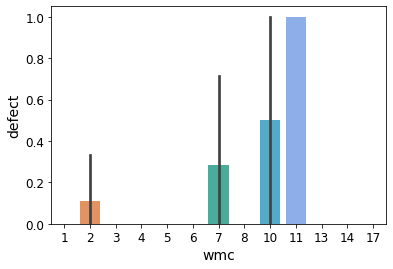

In [18]:
sns.barplot(x='wmc', y='defect', data=train_set)
plt.show()

## 3. Write a data preparation pipeline <a class='anchor' id='pipeline'></a>

Now let's build our preprocessing pipelines, starting with the pipeline for numerical attributes:

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

num_pipeline = Pipeline([
        ("imputer", SimpleImputer(missing_values = np.nan, strategy="median")),
        ("scaler", StandardScaler())
    ])

In [20]:
from sklearn.compose import ColumnTransformer

num_attribs = list(forrest.drop('name.1', axis=1)) # Forrest is without "name",'version',"name.1","defect"
cat_attribs = ["name.1"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs), #num_attribs transformed with num_pipeline
        ("cat", OneHotEncoder(handle_unknown = 'ignore'), cat_attribs),
    ])

forrest_prepared = full_pipeline.fit_transform(forrest)

Now we have a nice preprocessing pipeline that takes the raw data and outputs numerical input features and cat features that we can feed to any Machine Learning model we want.

## 4. Build the Forrest classifier <a class='anchor' id='build'></a>

Let's set the labels and the `X` matrix.

In [21]:
y_train = forrest_labels
X_train = full_pipeline.fit_transform(forrest)

In [22]:
X_train

array([[ 0.34949941, -0.60991521, -0.13867505, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.34949941, -0.60991521, -0.13867505, ...,  0.        ,
         0.        ,  0.        ],
       [-0.8853985 ,  0.6577517 , -0.13867505, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.63841892, -1.24374867, -0.13867505, ...,  0.        ,
         0.        ,  0.        ],
       [-0.14445976, -0.60991521,  7.21110255, ...,  0.        ,
         0.        ,  0.        ],
       [-0.63841892,  0.02391824, -0.13867505, ...,  0.        ,
         0.        ,  0.        ]])

Train a classifier. Let's start with a [`RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

In [23]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Great, our model is trained, let's use it to make predictions on the test set:

In [24]:
new_test_set = test_set.drop(['defect','version','name'], axis=1)
X_test = full_pipeline.transform(new_test_set)

In [25]:
y_pred = forest_clf.predict(X_test)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

## 5. Compute model performance metrics <a class='anchor' id='metrics'></a>

Let's use cross-validation with [cross_val_score()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) to have an idea of how good our model is.

In [26]:
from sklearn.model_selection import cross_val_score

k_fold = 5
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=k_fold)
forest_scores.mean()

0.8854545454545455

## 6. Build other models <a class='anchor' id='other'></a>

Let's try an [`SVC`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

In [27]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=k_fold)
svm_scores.mean()

0.9054545454545455

This model looks better than the random forest. Make a [boxplot()](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.boxplot.html).

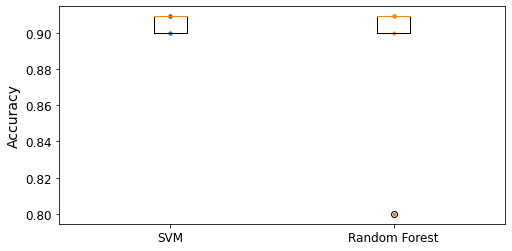

In [28]:
plt.figure(figsize=(8, 4))
plt.plot([1]*k_fold, svm_scores, ".")
plt.plot([2]*k_fold, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], labels=("SVM","Random Forest"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()

The SVM got a better score than the random forest classifier.